In [1]:
import numpy as np
import pandas as pd

import deepchem as dc

import sklearn
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from functools import reduce

import warnings
warnings.filterwarnings('ignore')

import pickle
from sklearn.feature_selection import VarianceThreshold
import matplotlib.pyplot as plt
import seaborn as sns

Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'pytorch_lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


In [2]:
data = pd.read_csv('../data/GABAA.csv',encoding='gb18030')

In [3]:
data

,name,origin,label,smiles,class
0,gamma-Aminobutyric acid,10.3390/molecules24152678,GABAA agonist,C(CC(=O)O)CN,1
1,Menthol,10.1111/bph.12602,GABAA agonist,CC1CCC(C(C1)O)C(C)C,1
2,phenobarbital,10.1002/ana.24967,GABAA agonist,CCC1(C(=O)NC(=O)NC1=O)C2=CC=CC=C2,1
3,isoguvacine oxide,10.1002/chir.530070608,GABAA agonist,C1CNCC2C1(O2)C(=O)O,1
4,Clomethiazole,10.1016/s0014-2999(02)02233-1,GABAA agonist,CC1=C(CCCl)SC=N1,1
...,...,...,...,...,...
483,chlorogenic acid,10.1021/jf0303971,GABAA inhibition,C1C(C(C(CC1(C(=O)O)O)OC(=O)C=CC2=CC(=C(C=C2)O)...,0
484,maltol,10.1021/jf0303971,GABAA inhibition,CC1=C(C(=O)C=CO1)O,0
485,Theobromine,10.1021/jf0303971,GABAA inhibition,CN1C=NC2=C1C(=O)NC(=O)N2C,0
486,"2,3,5-trimethylpyrazine",10.1021/jf0303971,GABAA inhibition,CN1C2=C(C(=O)N(C1=O)C)NC=N2,0


#  Load pre-trained models

In [4]:
with open('rf_maccs_model.pkl', 'rb') as f:
    rf_maccs_model = pickle.load(f)

In [5]:
rf_maccs_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 60,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [6]:
with open('rf_rdkit_model.pkl', 'rb') as f:
    rf_rdkit_model = pickle.load(f)

In [7]:
rf_rdkit_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 260,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [8]:
with open('svm_maccs_model.pkl', 'rb') as f:
    svm_maccs_model = pickle.load(f)

In [9]:
svm_maccs_model.get_params()

{'C': 1,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 0.1,
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': True,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [10]:
with open('xgb_maccs_model.pkl', 'rb') as f:
    xgb_maccs_model = pickle.load(f)

[00:35:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.



In [11]:
xgb_maccs_model.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': None,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.5,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.01,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 9,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 200,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

# Feature extraction function

In [12]:
def featurizer(featname,data):
    
    if featname =="MACCS":
        featurizer = dc.feat.MACCSKeysFingerprint()
        features = featurizer.featurize(data['smiles'])
        
        vt = VarianceThreshold(threshold = (.98 * (1 - .98)))

        
        X_new = vt.fit_transform(features)
        dataset = dc.data.NumpyDataset(X_new,data['class'])
        splitter = dc.splits.RandomSplitter()
        train_dataset, test_dataset = splitter.train_test_split(dataset=dataset,frac_train=0.8,seed=100)
        
        data_train = train_dataset.X
        data_test = test_dataset.X
        label_train = train_dataset.y
        label_test = test_dataset.y
    
    elif featname =="RDkit":
        featurizer = dc.feat.RDKitDescriptors()
        features = featurizer.featurize(data['smiles'])
        
        vt = VarianceThreshold(threshold = (.98 * (1 - .98)))

        
        X_new = vt.fit_transform(features)
        dataset = dc.data.NumpyDataset(X_new,data['class'])
        splitter = dc.splits.RandomSplitter()
        train_dataset, test_dataset = splitter.train_test_split(dataset=dataset,frac_train=0.8,seed=100)
        
        data_train = train_dataset.X
        data_test = test_dataset.X
        label_train = train_dataset.y
        label_test = test_dataset.y
     
    else:
        pass
    return  data_train, data_test, label_train, label_test

# Select the model

In [13]:
def SelectModel(modelname):

    if modelname == "rf_maccs":
        model = rf_maccs_model

    elif modelname == "rf_rdkit":
        model = rf_rdkit_model
        
    elif modelname == "svm_maccs":
        model = svm_maccs_model

    elif modelname == "xgb_maccs":
        model = xgb_maccs_model

    else:
        pass
    
    return model

In [14]:
# Function to perform k-fold cross-validation and obtain out-of-fold predictions
def get_oof(clf,n_folds,X_train,y_train,X_test):
    ntrain = X_train.shape[0]
    ntest =  X_test.shape[0]
    classnum = len(np.unique(y_train))
    kf = KFold(n_splits=n_folds,random_state=42,shuffle=True)
    oof_train = np.zeros((ntrain,classnum))
    oof_test = np.zeros((ntest,classnum))

    for i,(train_index, test_index) in enumerate(kf.split(X_train)):
        kf_X_train = X_train[train_index] 
        kf_y_train = y_train[train_index] 

        kf_X_test = X_train[test_index]  
        print(len(kf_X_train),
             len(kf_y_train),
             len(kf_X_test))
        #clf.fit(kf_X_train, kf_y_train)
        oof_train[test_index] = clf.predict_proba(kf_X_test)

        oof_test += clf.predict_proba(X_test)
    oof_test = oof_test/float(n_folds)
    
    return oof_train, oof_test

In [15]:
# First level stacking (feature transformation for second-level model)
modelist = ['rf_maccs','rf_rdkit','svm_maccs','xgb_maccs']
newfeature_list = []
newtestdata_list = []

for modelname in modelist:
    clf_first = SelectModel(modelname)
    
    if modelname == 'rf_maccs':
        data_train, data_test, label_train, label_test = featurizer('MACCS',data)
    elif modelname == 'rf_rdkit':
        data_train, data_test, label_train, label_test = featurizer('RDkit',data)
    elif modelname == 'svm_maccs':
        data_train, data_test, label_train, label_test = featurizer('MACCS',data)
    elif modelname == 'xgb_maccs':
        data_train, data_test, label_train, label_test = featurizer('MACCS',data)
    else:
        pass
        
    
    oof_train_ ,oof_test_= get_oof(clf=clf_first,n_folds=5,X_train=data_train,y_train=label_train,X_test=data_test)
    newfeature_list.append(oof_train_)
    newtestdata_list.append(oof_test_)

312 312 78
312 312 78
312 312 78
312 312 78
312 312 78
312 312 78
312 312 78
312 312 78
312 312 78
312 312 78
312 312 78
312 312 78
312 312 78
312 312 78
312 312 78
312 312 78
312 312 78
312 312 78
312 312 78
312 312 78


In [16]:
# Combine features from all models
newfeature = reduce(lambda x,y:np.concatenate((x,y),axis=1),newfeature_list)    
newtestdata = reduce(lambda x,y:np.concatenate((x,y),axis=1),newtestdata_list)

In [17]:
newfeature[0]

array([0.0743776 , 0.9256224 , 0.08153563, 0.91846437, 0.0963335 ,
       0.9036665 , 0.12558389, 0.87441611])

In [27]:

# Second level stacking model training
clf_second1 = RandomForestClassifier()
clf_second1.fit(newfeature, label_train)

RandomForestClassifier()

# seed=100

In [16]:
# Make predictions
pred_proba = clf_second1.predict_proba(newtestdata)
y_test_pred = clf_second1.predict(newtestdata)

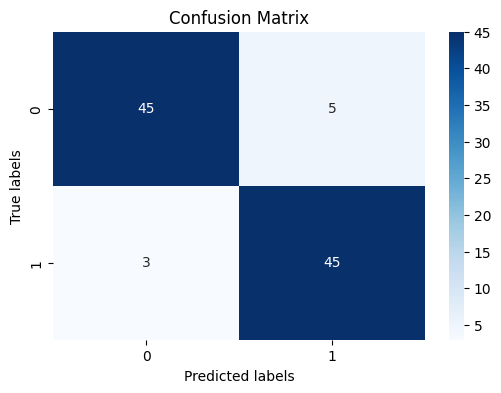

In [17]:
# Confusion matrix visualization
confusion_mat_1 = confusion_matrix(label_test, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mat_1, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

In [18]:
# Compute performance metrics
test_pred_list = []
for test_score in pred_proba:
    test_score = test_score[1]
    test_pred_list.append(test_score)

In [19]:
test_pred_array = np.array(test_pred_list)

In [20]:
auc = roc_auc_score(label_test, test_pred_array)
acc = accuracy_score(label_test, np.round(test_pred_array))
pre = precision_score(label_test, np.round(test_pred_array))
rec = recall_score(label_test, np.round(test_pred_array))

print(auc,acc,pre,rec)

0.9795833333333333 0.9183673469387755 0.9 0.9375


# seed=200

In [13]:
# Make predictions
pred_proba = clf_second1.predict_proba(newtestdata)
y_test_pred = clf_second1.predict(newtestdata)

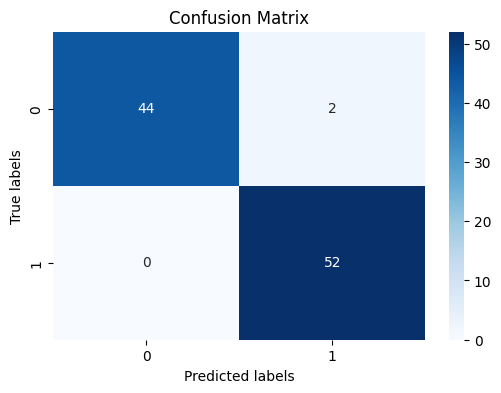

In [21]:
# Confusion matrix visualization
confusion_mat_2 = confusion_matrix(label_test, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mat_2, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

In [22]:
# Compute performance metrics
test_pred_list = []
for test_score in pred_proba:
    test_score = test_score[1]
    test_pred_list.append(test_score)

In [23]:
test_pred_array = np.array(test_pred_list)

In [24]:
auc = roc_auc_score(label_test, test_pred_array)
acc = accuracy_score(label_test, np.round(test_pred_array))
pre = precision_score(label_test, np.round(test_pred_array))
rec = recall_score(label_test, np.round(test_pred_array))

print(auc,acc,pre,rec)

0.9993729096989966 0.9795918367346939 0.9629629629629629 1.0


# seed=300

In [31]:
# Make predictions
pred_proba = clf_second1.predict_proba(newtestdata)
y_test_pred = clf_second1.predict(newtestdata)

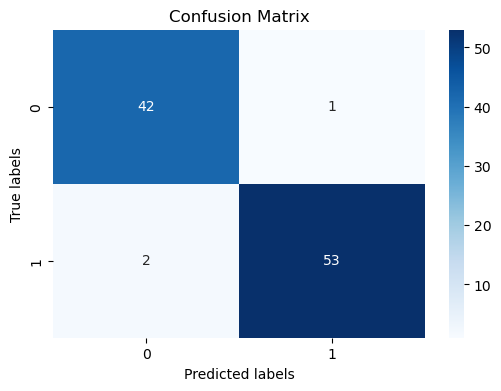

In [32]:
# Confusion matrix visualization
confusion_mat_3 = confusion_matrix(label_test, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

In [33]:
# Compute performance metrics
test_pred_list = []
for test_score in pred_proba:
    test_score = test_score[1]
    test_pred_list.append(test_score)

In [34]:
test_pred_array = np.array(test_pred_list)

In [35]:
auc = roc_auc_score(label_test, test_pred_array)
acc = accuracy_score(label_test, np.round(test_pred_array))
pre = precision_score(label_test, np.round(test_pred_array))
rec = recall_score(label_test, np.round(test_pred_array))

print(auc,acc,pre,rec)

0.9983086680761099 0.9693877551020408 0.9814814814814815 0.9636363636363636


# seed=400

In [114]:
# Make predictions
pred_proba = clf_second1.predict_proba(newtestdata)
y_test_pred = clf_second1.predict(newtestdata)

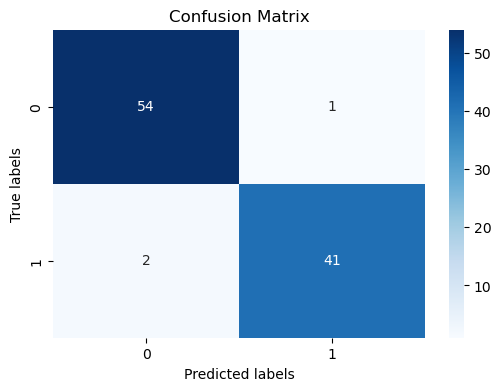

In [115]:
# Confusion matrix visualization
confusion_mat_4 = confusion_matrix(label_test, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

In [116]:
# Compute performance metrics
test_pred_list = []
for test_score in pred_proba:
    test_score = test_score[1]
    test_pred_list.append(test_score)

In [117]:
test_pred_array = np.array(test_pred_list)

In [118]:
auc = roc_auc_score(label_test, test_pred_array)
acc = accuracy_score(label_test, np.round(test_pred_array))
pre = precision_score(label_test, np.round(test_pred_array))
rec = recall_score(label_test, np.round(test_pred_array))

print(auc,acc,pre,rec)

0.9978858350951374 0.9693877551020408 0.9761904761904762 0.9534883720930233


# seed=500

In [20]:
# Make predictions
pred_proba = clf_second1.predict_proba(newtestdata)
y_test_pred = clf_second1.predict(newtestdata)

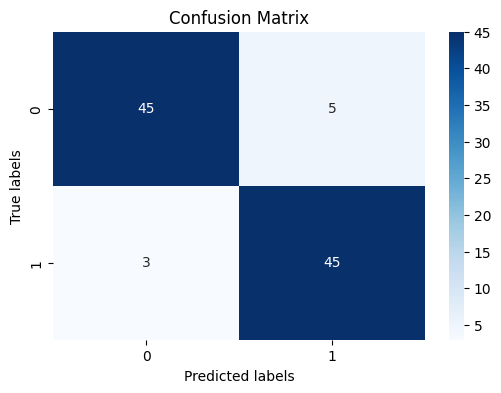

In [21]:
# Confusion matrix visualization
confusion_mat_5 = confusion_matrix(label_test, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mat_5, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

In [22]:
# Compute performance metrics
test_pred_list = []
for test_score in pred_proba:
    test_score = test_score[1]
    test_pred_list.append(test_score)

In [23]:
test_pred_array = np.array(test_pred_list)

In [24]:
auc = roc_auc_score(label_test, test_pred_array)
acc = accuracy_score(label_test, np.round(test_pred_array))
pre = precision_score(label_test, np.round(test_pred_array))
rec = recall_score(label_test, np.round(test_pred_array))

print(auc,acc,pre,rec)

0.9795833333333333 0.9183673469387755 0.9 0.9375


In [28]:
import pickle

# 保存第二层随机森林模型
with open('stacking_model.pkl', 'wb') as f:
    pickle.dump(clf_second1, f)

# Ave_confusion_matrix

In [2]:
confusion_mat_ave = np.array([[45,2.2],[1.6,49.2]])

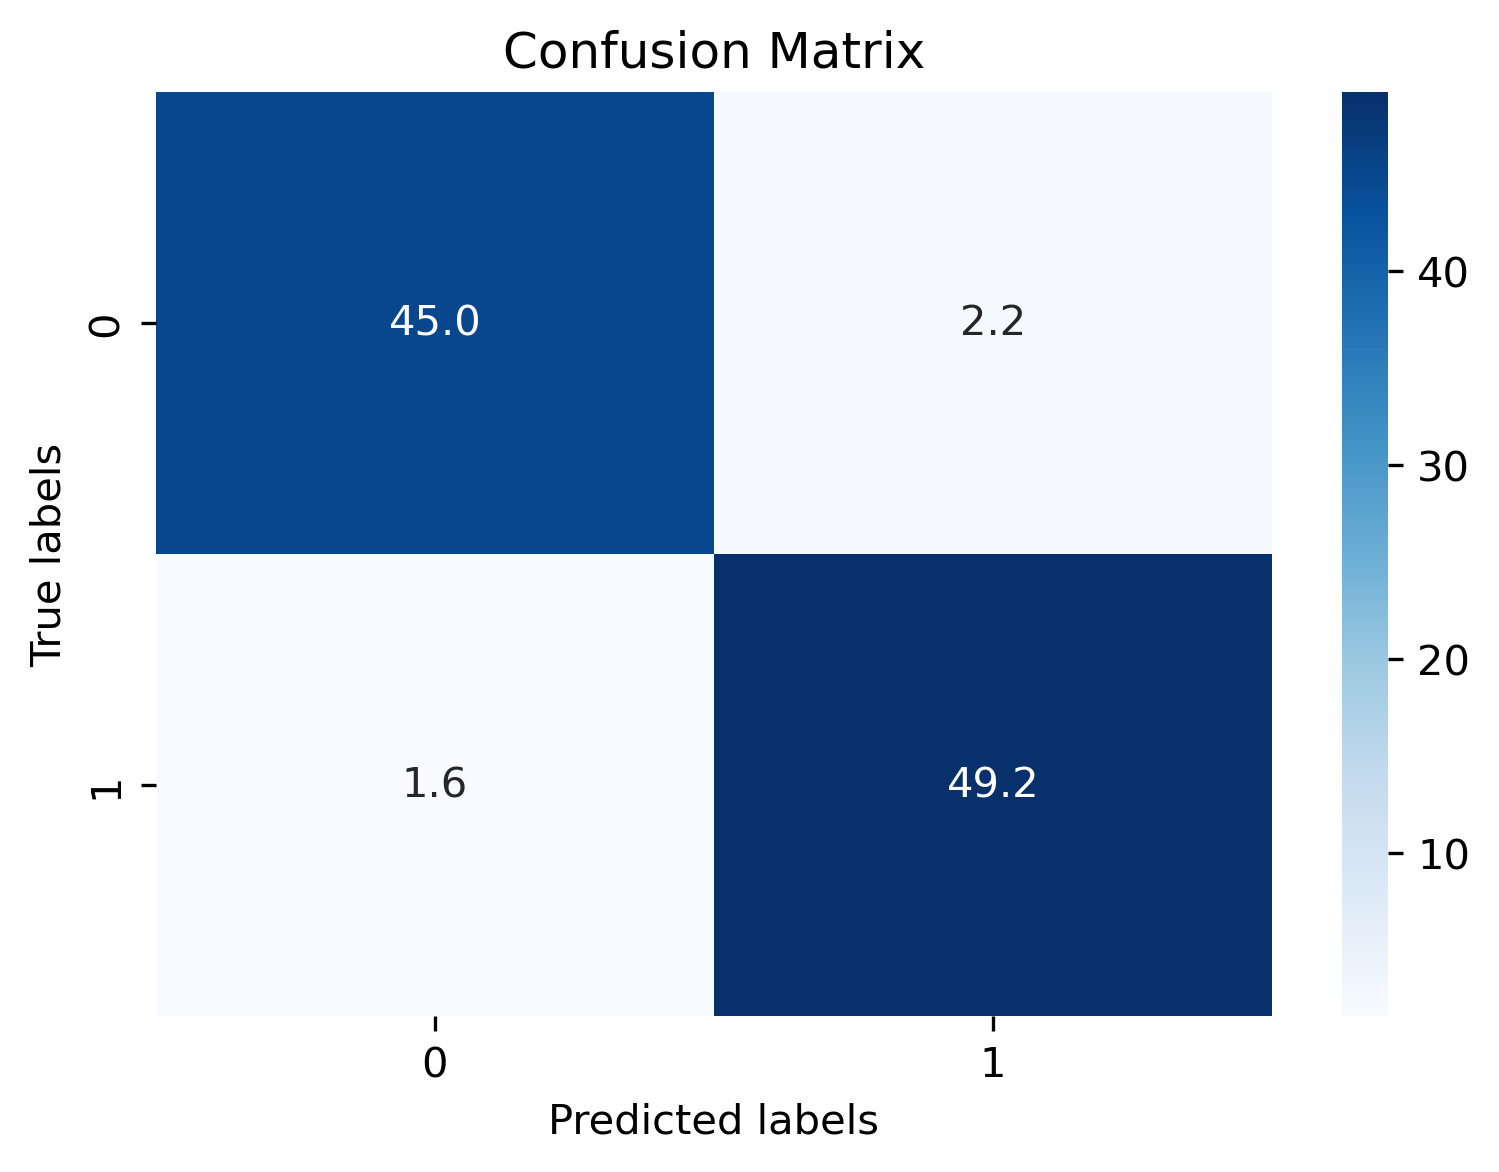

In [5]:
plt.rcParams['figure.dpi'] = 300
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mat_ave, annot=True, fmt=".1f", cmap="Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()